<img width="800px" src="../fidle/img/00-Fidle-header-01.svg"></img>

# <!-- TITLE --> [VAE8] - Variational AutoEncoder (VAE) with CelebA (small)
<!-- DESC --> Variational AutoEncoder (VAE) with CelebA (small res. 128x128)
<!-- AUTHOR : Jean-Luc Parouty (CNRS/SIMaP) -->

## Objectives :
 - Build and train a VAE model with a large dataset in **small resolution(>70 GB)**
 - Understanding a more advanced programming model with **data generator**

The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) contains about 200,000 images (202599,218,178,3).  

## What we're going to do :

 - Defining a VAE model
 - Build the model
 - Train it
 - Follow the learning process with Tensorboard

## Acknowledgements :
As before, thanks to **François Chollet** who is at the base of this example.  
See : https://keras.io/examples/generative/vae


## Step 1 - Init python stuff

In [1]:
import numpy as np
from skimage import io

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard

import os,sys,json,time,datetime
from IPython.display import display,Image,Markdown,HTML

from modules.data_generator import DataGenerator
from modules.VAE            import VAE, Sampling
from modules.callbacks      import ImagesCallback, BestModelCallback

sys.path.append('..')
import fidle.pwk as pwk

run_dir = './run/CelebA-s.001'                  # Output directory
datasets_dir = pwk.init('VAE8', run_dir)

VAE.about()
DataGenerator.about()

**FIDLE 2020 - Practical Work Module**

Version              : 0.6.1 DEV
Notebook id          : VAE8
Run time             : Tuesday 5 January 2021, 14:49:56
TensorFlow version   : 2.4.0
Keras version        : 2.4.0
Datasets dir         : /gpfswork/rech/mlh/uja62cb/datasets
Run dir              : ./run/CelebA-s.001
CI running mode      : none
Update keras cache   : False
Save figs            : True
Path figs            : ./run/CelebA-s.001/figs


<br>**FIDLE 2021 - VAE**

Version              : 1.2
TensorFlow version   : 2.4.0
Keras version        : 2.4.0


<br>**FIDLE 2020 - DataGenerator**

Version              : 0.4.1
TensorFlow version   : 2.4.0
Keras version        : 2.4.0


In [2]:
# To clean run_dir, uncomment and run this next line
# ! rm -r "$run_dir"/images-* "$run_dir"/logs "$run_dir"/figs "$run_dir"/models ; rmdir "$run_dir"

rm: cannot remove './run/CelebA-s.001/logs': No such file or directory


## Step 2 - Get some data
Let's instantiate our generator for the entire dataset.

### 1.1 - Parameters
Uncomment the right lines according to the data you want to use

In [3]:
# ---- For tests
# scale        = 0.3
# image_size   = (128,128)
# enhanced_dir = './data'

# ---- Training with a full dataset
scale        = 1.
image_size   = (128,128)
enhanced_dir = f'{datasets_dir}/celeba/enhanced'

# ---- Training with a full dataset of large images
# scale        = 1.
# image_size   = (192,160)
# enhanced_dir = f'{datasets_dir}/celeba/enhanced'

### 1.2 - Finding the right place

In [4]:
# ---- Used for continous integration or batch mode - Just forget this 2 lines
#
scale        = pwk.override('scale',        scale)
image_size   = pwk.override('image_size',   image_size)
enhanced_dir = pwk.override('enhanced_dir', enhanced_dir)

# ---- the place of the clusters files
#
lx,ly      = image_size
train_dir  = f'{enhanced_dir}/clusters-{lx}x{ly}'
print('Train directory is :',train_dir)

Train directory is : /gpfswork/rech/mlh/uja62cb/datasets/celeba/enhanced/clusters-128x128


### 1.2 - Get a DataGenerator

In [5]:
data_gen = DataGenerator(train_dir, 32, k_size=scale)

print(f'Data generator is ready with : {len(data_gen)} batchs of {data_gen.batch_size} images, or {data_gen.dataset_size} images')

Data generator is ready with : 6331 batchs of 32 images, or 202599 images


## Step 3 - Build model

In [6]:
latent_dim = 300

#### Encoder

In [7]:
inputs    = keras.Input(shape=(lx, ly, 3))
x         = layers.Conv2D(32, 3, strides=2, padding="same", activation="relu")(inputs)
x         = layers.Conv2D(64, 3, strides=2, padding="same", activation="relu")(x)
x         = layers.Conv2D(64, 3, strides=2, padding="same", activation="relu")(x)
x         = layers.Conv2D(64, 3, strides=2, padding="same", activation="relu")(x)

shape_before_flattening = keras.backend.int_shape(x)[1:]

x         = layers.Flatten()(x)
x         = layers.Dense(512, activation="relu")(x)

z_mean    = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z         = Sampling()([z_mean, z_log_var])

encoder = keras.Model(inputs, [z_mean, z_log_var, z], name="encoder")
encoder.compile()
# encoder.summary()

#### Decoder

In [8]:
inputs  = keras.Input(shape=(latent_dim,))

x = layers.Dense(np.prod(shape_before_flattening))(inputs)
x = layers.Reshape(shape_before_flattening)(x)

x       = layers.Conv2DTranspose(64, 3, strides=2, padding="same", activation="relu")(x)
x       = layers.Conv2DTranspose(64, 3, strides=2, padding="same", activation="relu")(x)
x       = layers.Conv2DTranspose(64, 3, strides=2, padding="same", activation="relu")(x)
x       = layers.Conv2DTranspose(32, 3, strides=2, padding="same", activation="relu")(x)
outputs = layers.Conv2DTranspose(3,  3, padding="same", activation="sigmoid")(x)

decoder = keras.Model(inputs, outputs, name="decoder")
decoder.compile()
# decoder.summary()

#### VAE
Our loss function is the weighted sum of two values.  
`reconstruction_loss` which measures the loss during reconstruction.  
`kl_loss` which measures the dispersion.  

The weights are defined by: `r_loss_factor` :  
`total_loss = r_loss_factor*reconstruction_loss + (1-r_loss_factor)*kl_loss`

if `r_loss_factor = 1`, the loss function includes only `reconstruction_loss`  
if `r_loss_factor = 0`, the loss function includes only `kl_loss`  
In practice, a value arround 0.5 gives good results here.


In [9]:
vae = VAE(encoder, decoder, r_loss_factor=0.6)

vae.compile(optimizer=keras.optimizers.Adam())

Init VAE, with r_loss_factor=0.6


## Step 4 - Train
20' on a CPU  
1'12 on a GPU (V100, IDRIS)

### 4.1 - Callbacks

In [10]:
x_draw,_   = data_gen[0]
data_gen.rewind()

# ---- Callback : Images encoded
pwk.mkdir(run_dir + '/images-encoded')
filename = run_dir + '/images-encoded/image-{epoch:03d}-{i:02d}.jpg'
callback_images1 = ImagesCallback(filename, x=x_draw[:5], encoder=encoder,decoder=decoder)

# ---- Callback : Images generated
pwk.mkdir(run_dir + '/images-generated')
filename = run_dir + '/images-generated/image-{epoch:03d}-{i:02d}.jpg'
callback_images2 = ImagesCallback(filename, x=None, nb_images=5, z_dim=latent_dim, encoder=encoder,decoder=decoder)          

# ---- Callback : Best model
pwk.mkdir(run_dir + '/models')
filename = run_dir + '/models/best_model'
callback_bestmodel = BestModelCallback(filename)

# ---- Callback tensorboard
dirname = run_dir + '/logs'
callback_tensorboard = TensorBoard(log_dir=dirname, histogram_freq=1)

callbacks_list = [callback_images1, callback_images2, callback_bestmodel, callback_tensorboard]
callbacks_list = [callback_images1, callback_images2, callback_bestmodel]

### 4.2 - Train it

In [11]:
batch_size = 64
epochs     = 15

pwk.chrono_start()

history = vae.fit(data_gen, epochs=epochs, batch_size=batch_size, callbacks=callbacks_list)

pwk.chrono_show()

Epoch 1/15
6331/6331 [==============================] - 124s 19ms/step - loss: 0.3531 - r_loss: 0.5684 - kl_loss: 0.0302
           (saved)
Epoch 2/15
6331/6331 [==============================] - 124s 20ms/step - loss: 0.3447 - r_loss: 0.5524 - kl_loss: 0.0332
           (saved)
Epoch 3/15
6331/6331 [==============================] - 118s 19ms/step - loss: 0.3436 - r_loss: 0.5499 - kl_loss: 0.0341
Epoch 4/15
6331/6331 [==============================] - 116s 18ms/step - loss: 0.3431 - r_loss: 0.5489 - kl_loss: 0.0344
Epoch 5/15
6331/6331 [==============================] - 121s 19ms/step - loss: 0.3427 - r_loss: 0.5479 - kl_loss: 0.0348
Epoch 6/15
6331/6331 [==============================] - 118s 19ms/step - loss: 0.3425 - r_loss: 0.5474 - kl_loss: 0.0351
           (saved)
Epoch 7/15
6331/6331 [==============================] - 123s 19ms/step - loss: 0.3422 - r_loss: 0.5468 - kl_loss: 0.0354
           (saved)
Epoch 8/15
6331/6331 [==============================] - 113s 18ms/step - loss

## Step 5 - About our training session
### 5.1 - History

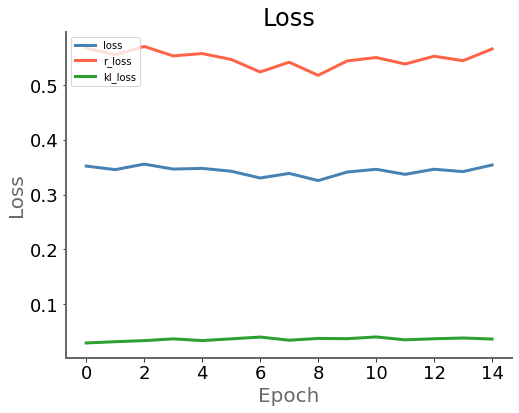

In [12]:
pwk.plot_history(history,  plot={"Loss":['loss','r_loss', 'kl_loss']}, save_as='01-history')

### 5.2 - Reconstruction (input -> encoder -> decoder)

<br>**Original images :**

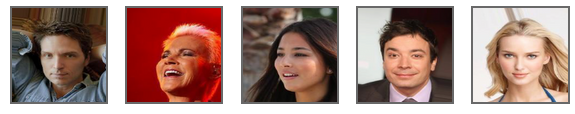

<br>**Encoded/decoded images**

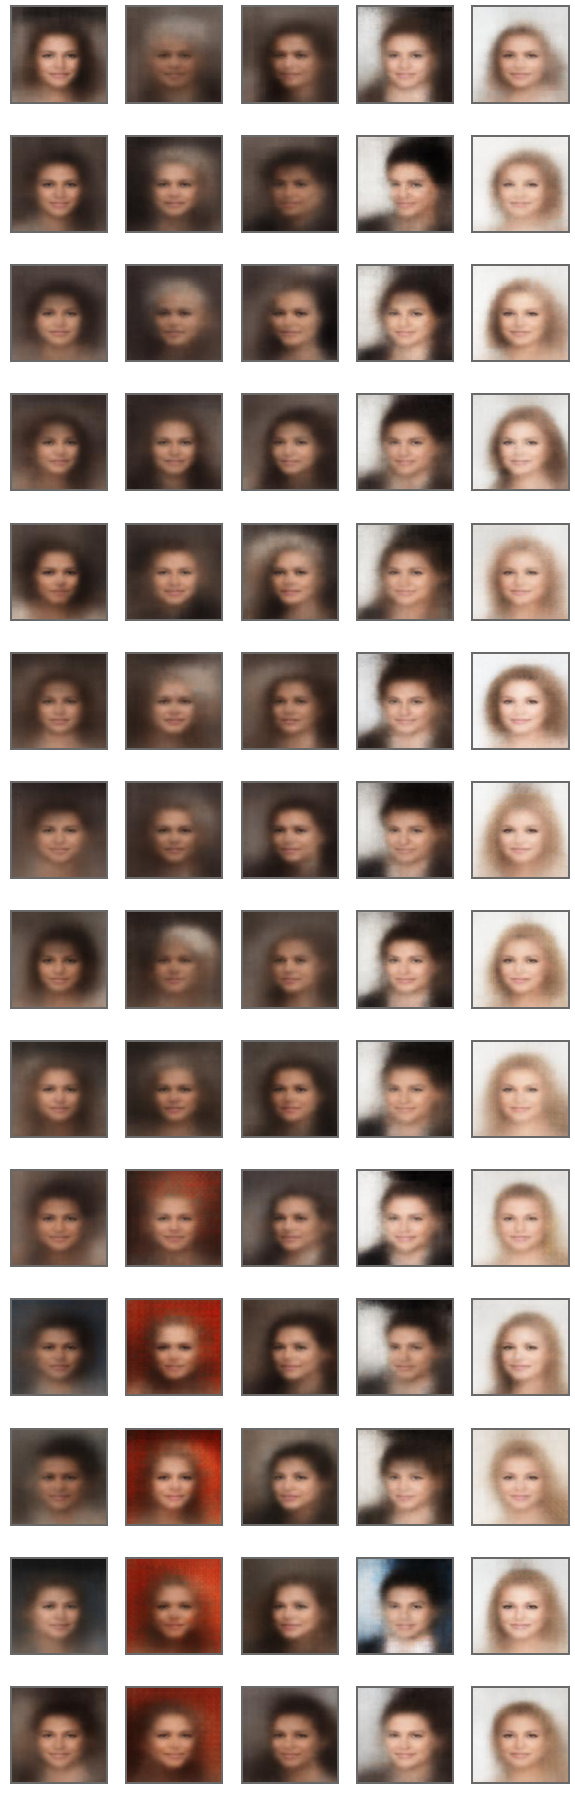

<br>**Original images :**

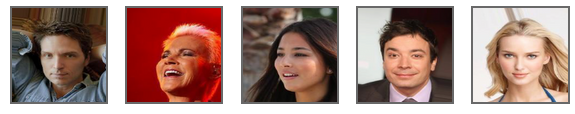

In [13]:
imgs=[]
labels=[]
for epoch in range(1,epochs,1):
    for i in range(5):
        filename = f'{run_dir}/images-encoded/image-{epoch:03d}-{i:02d}.jpg'.format(epoch=epoch, i=i)
        img      = io.imread(filename)
        imgs.append(img)
        

pwk.subtitle('Original images :')
pwk.plot_images(x_draw[:5], None, indices='all', columns=5, x_size=2,y_size=2, save_as='02-original')

pwk.subtitle('Encoded/decoded images')
pwk.plot_images(imgs, None, indices='all', columns=5, x_size=2,y_size=2, save_as='03-reconstruct')

pwk.subtitle('Original images :')
pwk.plot_images(x_draw[:5], None, indices='all', columns=5, x_size=2,y_size=2, save_as=None)


### 5.3 Generation (latent -> decoder)

<br>**Generated images from latent space**

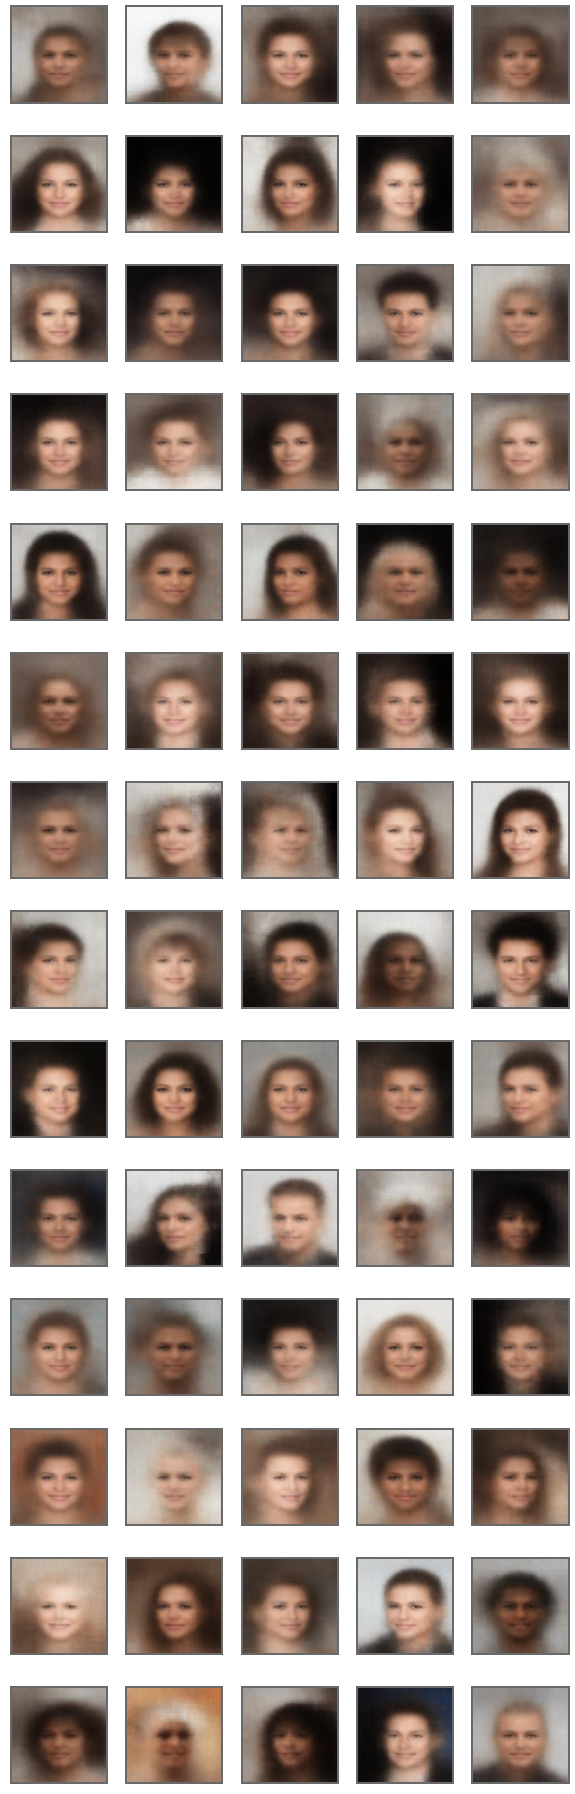

In [14]:
imgs=[]
labels=[]
for epoch in range(1,epochs,1):
    for i in range(5):
        filename = f'{run_dir}/images-generated/image-{epoch:03d}-{i:02d}.jpg'.format(epoch=epoch, i=i)
        img      = io.imread(filename)
        imgs.append(img)
        
pwk.subtitle('Generated images from latent space')
pwk.plot_images(imgs, None, indices='all', columns=5, x_size=2,y_size=2, save_as='04-encoded')


In [15]:
pwk.end()

End time is : Tuesday 5 January 2021, 15:20:52
Duration is : 00:30:56 686ms
This notebook ends here


---
<img width="80px" src="../fidle/img/00-Fidle-logo-01.svg"></img>